In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn  as sbn
import plotly.graph_objects as go
from sklearn.metrics import ConfusionMatrixDisplay
import plotly.express as px
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split#, StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
%matplotlib inline

from Constants import *

In [2]:
seed = 8
np.random.seed(seed)

In [3]:
dataset = pd.read_csv(DATASET)
dataset.head(1)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0


In [4]:
dataset = dataset.drop("dataset",  axis = 1)
dataset = dataset.drop( "id",  axis = 1)
dataset.rename({'num' : 'target'}, axis = 'columns', inplace = True)

In [5]:
data = dataset.copy()

In [6]:
data.head(1)

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0


In [7]:
data.shape

(920, 14)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   cp        920 non-null    object 
 3   trestbps  861 non-null    float64
 4   chol      890 non-null    float64
 5   fbs       830 non-null    object 
 6   restecg   918 non-null    object 
 7   thalch    865 non-null    float64
 8   exang     865 non-null    object 
 9   oldpeak   858 non-null    float64
 10  slope     611 non-null    object 
 11  ca        309 non-null    float64
 12  thal      434 non-null    object 
 13  target    920 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 100.8+ KB


In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,920.0,53.510870,9.424685,28.0,47.0,54.0,60.0,77.0
trestbps,861.0,132.132404,19.066070,0.0,120.0,130.0,140.0,200.0
chol,890.0,199.130337,110.780810,0.0,175.0,223.0,268.0,603.0
thalch,865.0,137.545665,25.926276,60.0,120.0,140.0,157.0,202.0
oldpeak,858.0,0.878788,1.091226,-2.6,0.0,0.5,1.5,6.2
ca,309.0,0.676375,0.935653,0.0,0.0,0.0,1.0,3.0
target,920.0,0.995652,1.142693,0.0,0.0,1.0,2.0,4.0


In [10]:
data.mode()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,54,Male,asymptomatic,120.0,0.0,False,normal,150.0,False,0.0,flat,0.0,normal,0


In [11]:
# Handling null values

data.isnull().sum()

age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64

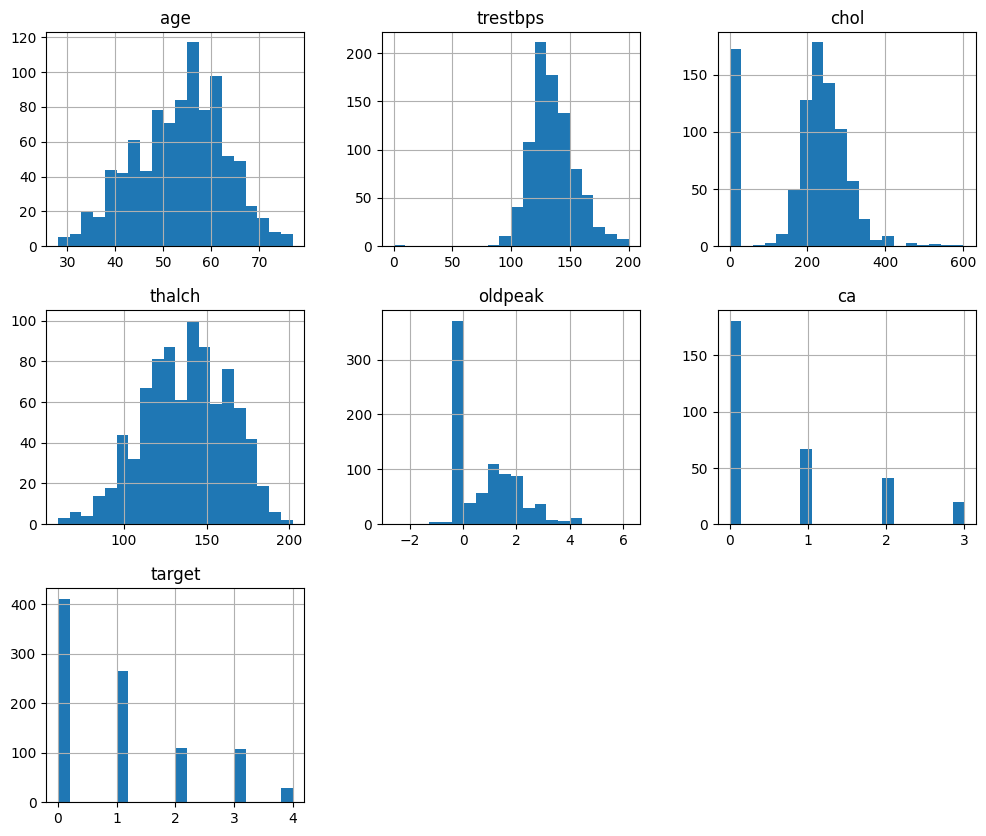

In [12]:
hist = data.hist(bins = 20, figsize = (12, 10))

In [13]:
print(data["sex"].unique())
print(data["cp"].unique())
print(data["fbs"].unique())
print(data["restecg"].unique())
print(data["exang"].unique())
print(data["slope"].unique())
print(data["thal"].unique())
print(data["target"].unique())

['Male' 'Female']
['typical angina' 'asymptomatic' 'non-anginal' 'atypical angina']
[True False nan]
['lv hypertrophy' 'normal' 'st-t abnormality' nan]
[False True nan]
['downsloping' 'flat' 'upsloping' nan]
['fixed defect' 'normal' 'reversable defect' nan]
[0 2 1 3 4]


In [14]:
data['target'] = data['target'].apply(lambda x: 1 if x != 0 else 0)

Categorical features in the data have some columns in the data containing unsupported values;

- cp: chest pain type, has four possible outcomes.
- sex: male or female.
- fbs: fasting blood sugar, 1 if greater than 120 mg/dl, 0 if false.
- restecg: resting electrocardiographic results, three possible values.
- exang: exercise induced angina, 1 for yes 0 for no.
- slope: the slope of the peak excercise ST segment, three possible outcomes
- thal: three possible outcomes, 1 normal, 2 fixed defect and 0 reversible defect.
- target: 1 has disease, 0 doesn't.

In [15]:
# revisit this if model performs poorly

restecg = data['restecg'].mode()[0]
data['restecg'].fillna(restecg, inplace = True)

mean = data['trestbps'].mean(skipna = True)
median = data['trestbps'].median(skipna = True)
#avg = (mean + median) / 2
avg = median
data['trestbps'].fillna(avg, inplace = True)

mean = data['chol'].mean(skipna = True)
median = data['chol'].median(skipna = True)
#avg = (mean + median) / 2
#avg = median
data['chol'].fillna(avg, inplace = True)

mean = data['thalch'].mean(skipna = True)
median = data['thalch'].median(skipna = True)
#avg = (mean + median) / 2
avg = mean
data['thalch'].fillna(avg, inplace = True)

mean = data['oldpeak'].mean(skipna = True)
median = data['oldpeak'].median(skipna = True)
#avg = (mean + median) / 2
avg = mean
data['oldpeak'].fillna(avg, inplace = True)

In [16]:
#data.median()

In [17]:
# Handling null values

data.isnull().sum()

age           0
sex           0
cp            0
trestbps      0
chol          0
fbs          90
restecg       0
thalch        0
exang        55
oldpeak       0
slope       309
ca          611
thal        486
target        0
dtype: int64

In [18]:
data.dropna(inplace = True)

In [19]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [20]:
data.shape

(299, 14)

In [21]:
lab_enc = LabelEncoder()
data['sex'] = lab_enc.fit_transform(data['sex'])
data['cp'] = lab_enc.fit_transform(data['cp'])
data['fbs'] = lab_enc.fit_transform(data['fbs'])
data['restecg'] = lab_enc.fit_transform(data['restecg'])
data['exang'] = lab_enc.fit_transform(data['exang'])
data['slope'] = lab_enc.fit_transform(data['slope'])
data['thal'] = lab_enc.fit_transform(data['thal'])

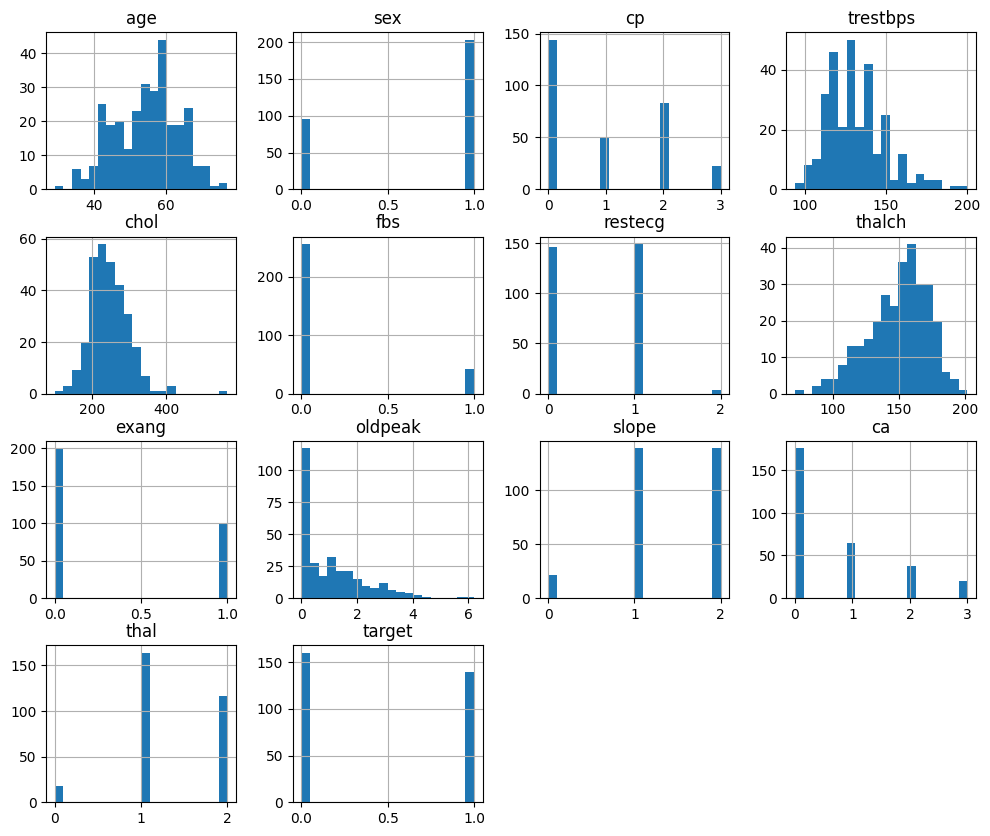

In [22]:
# Histogram of features

hist = data.hist(bins = 20, figsize = (12, 10))

Highest age:  77 Lowest age:  29


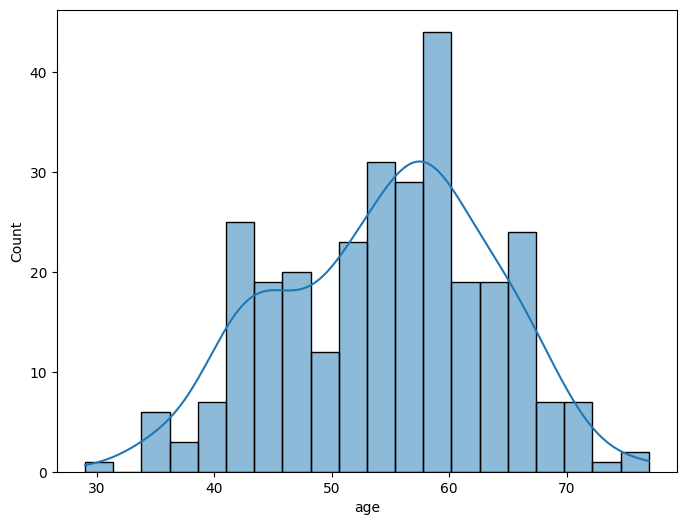

In [23]:
# Age distribution

plt.figure(figsize = (8, 6))
sbn.histplot(data['age'], kde = True, bins = 20)
print("Highest age: ", data['age'].max(), "Lowest age: ", data['age'].min())

In [24]:
cp_ranges = {
    'Type 0': ['Type 0', 0],
    'Type 1': ['Type 1', 1],
    'Type 2': ['Type 2', 2],
    'Type 3': ['Type 3', 3]
}

chest_pain = data.groupby(pd.cut(data['cp'], 
                                bins = [-float('inf')]+[i[1] for i in cp_ranges.values()], 
                                labels = cp_ranges.keys())).size().to_dict()

colors = {'Type 0': '#afafaf',
          'Type 1': '#666666',
          'Type 2': '#333333',
          'Type 3': '#000000'}

fig = go.Figure(data=[go.Pie(labels=list(chest_pain.keys()), values=list(chest_pain.values()),
                             marker=dict(colors=list(colors.values())))])
fig.update_layout(title='Chest Pain', showlegend = True)
fig.show()

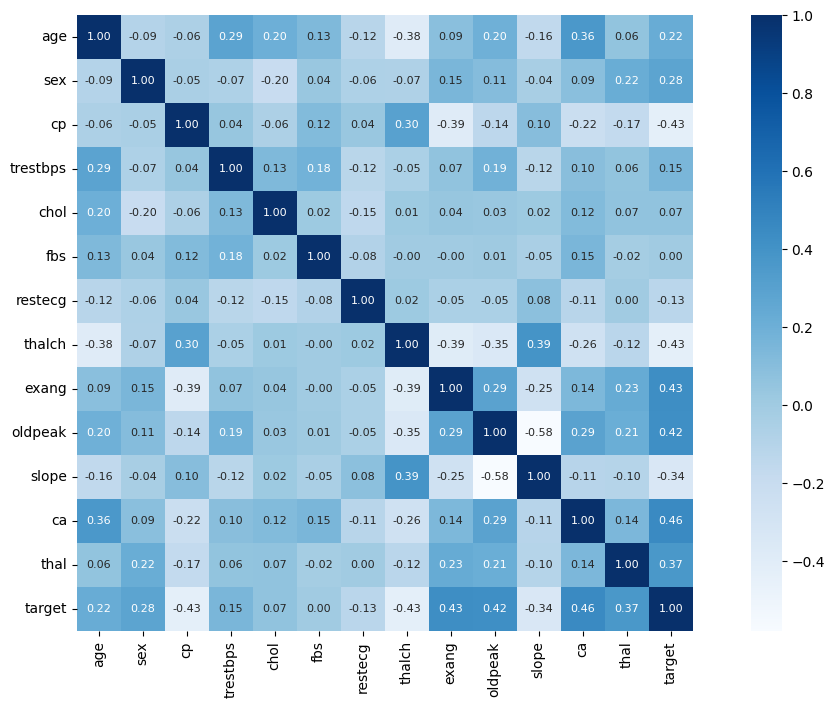

In [25]:
# Feature Correlation

corrmat = data.corr()

plt.figure(figsize=(15, 8))

hm = sbn.heatmap(corrmat,
                 cbar = True,
                 annot = True,
                 square = True,
                 fmt = '.2f',
                 annot_kws = {'size': 8}, 
                 yticklabels = data.columns, 
                 xticklabels = data.columns, 
                 cmap = "Blues"                 
                 )

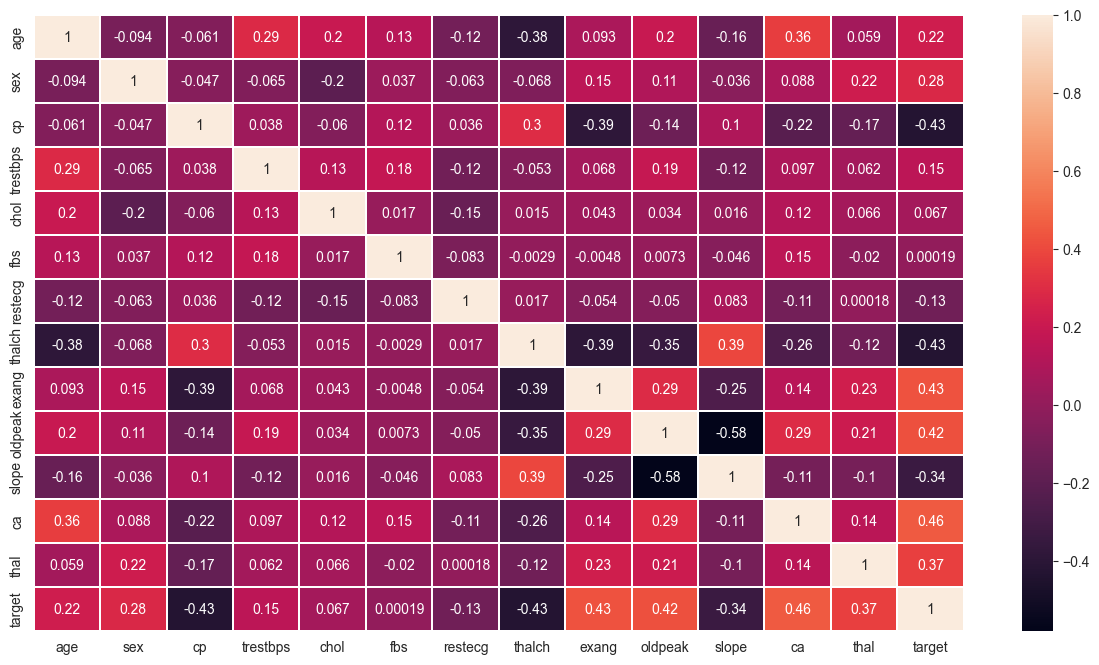

In [26]:
sbn.set_style('whitegrid')
plt.figure(figsize = (15, 8))
sbn.heatmap(data.corr(), annot = True, linewidths = .3)
plt.show()

Text(0.5, 1.0, 'Target Counts')

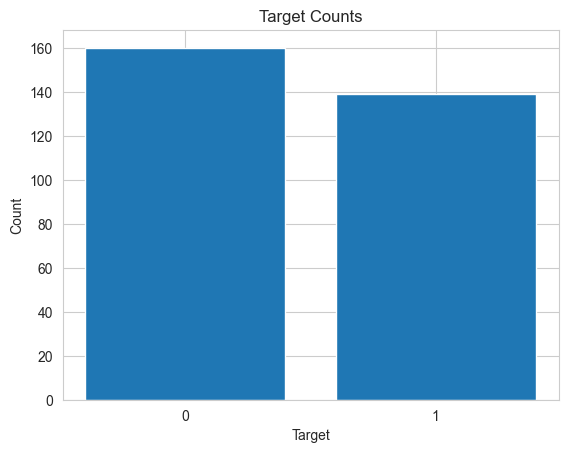

In [27]:
plt.bar(data['target'].unique(), data['target'].value_counts())
plt.xticks([0, 1])
plt.xlabel("Target")
plt.ylabel("Count")
plt.title("Target Counts")

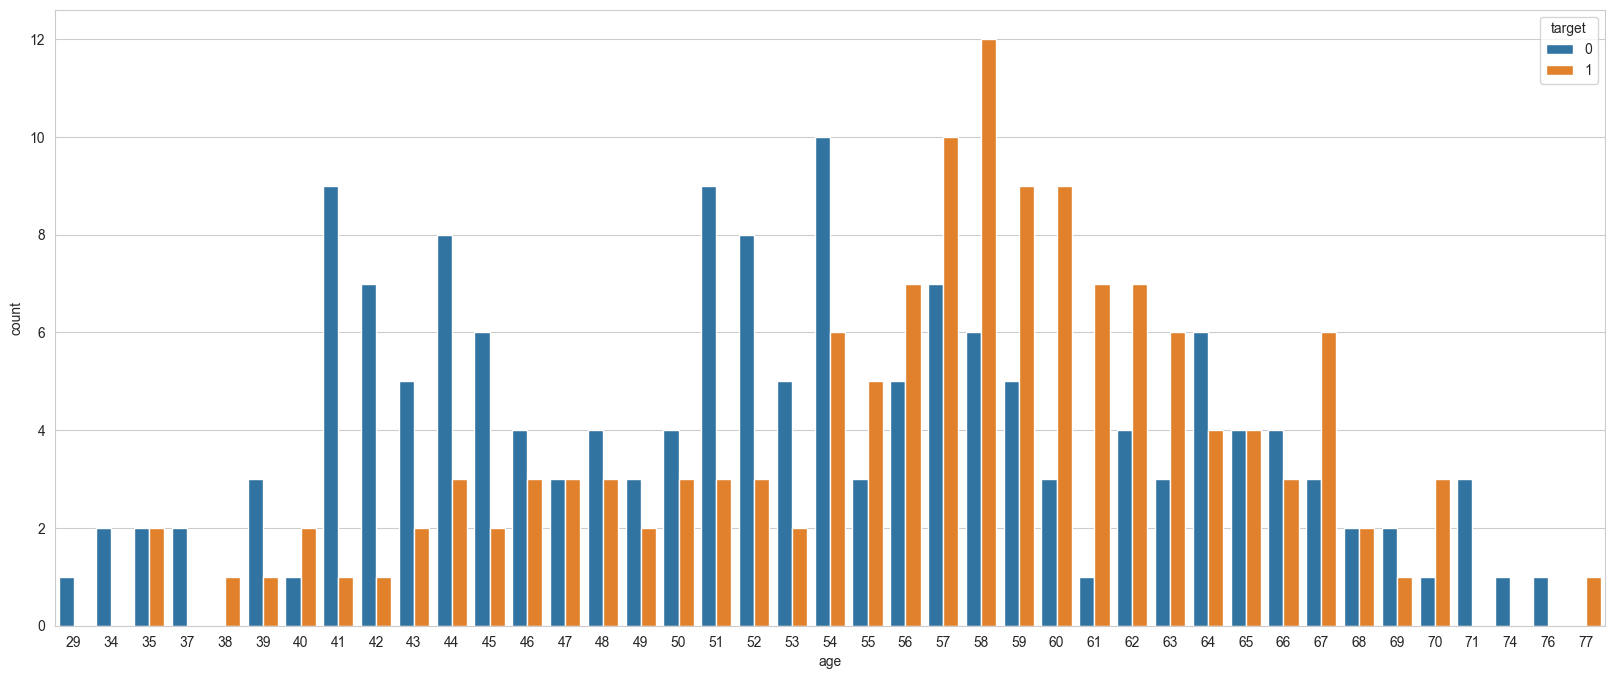

In [28]:
plt.figure(figsize = (20, 8))
sbn.countplot(x = 'age', data = data, hue = 'target')
plt.show()

In [29]:
# Feature and Target selection

X = data.drop('target', axis = 1)
Y = data['target']
print(X.shape)
print(Y.shape)

(299, 13)
(299,)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify = Y, test_size = 0.25, random_state = 69, shuffle = True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train)

X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(224, 13) (224,)
(75, 13) (75,)


In [31]:
# Define the XGBClassifier xgb_class
xgb_class = XGBClassifier(max_depth = 7,
                          n_estimators = 150,
                          colsample_bytree = 0.9,
                          max_leaves = 15,
                          min_child_weight = 11,
                          gamma = 4
                          )

# Fit the xgb_class to the training data
xgb_class.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=4, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=15,
              min_child_weight=11, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [32]:
y_pred = xgb_class.predict(X_test)

In [33]:
# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("XGBClassifier accuracy: %.2f%% " % (accuracy * 100))

# Compute the feature importance
feature_importances = xgb_class.feature_importances_ * 100
print("Feature importances:")
print(feature_importances)

#correct this

XGBClassifier accuracy: 84.00% 
Feature importances:
[ 8.5610485  5.198743  25.285105   0.         0.         0.
  0.         5.113468  17.287151  12.782036   0.        10.576696
 15.195753 ]


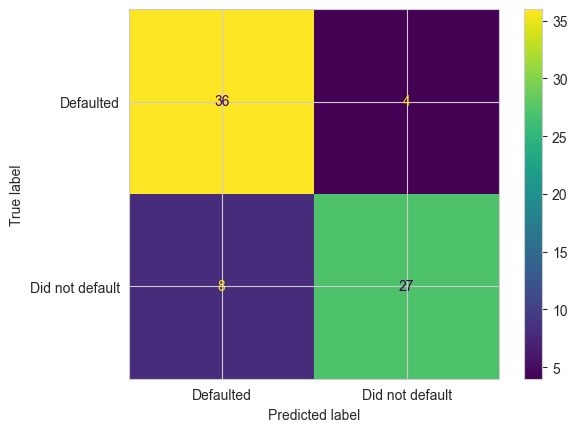

In [34]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

conf_mat = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Defaulted", "Did not default"])

conf_mat.plot()
plt.show()

Text(0.5, 1.0, 'Feature Importance')

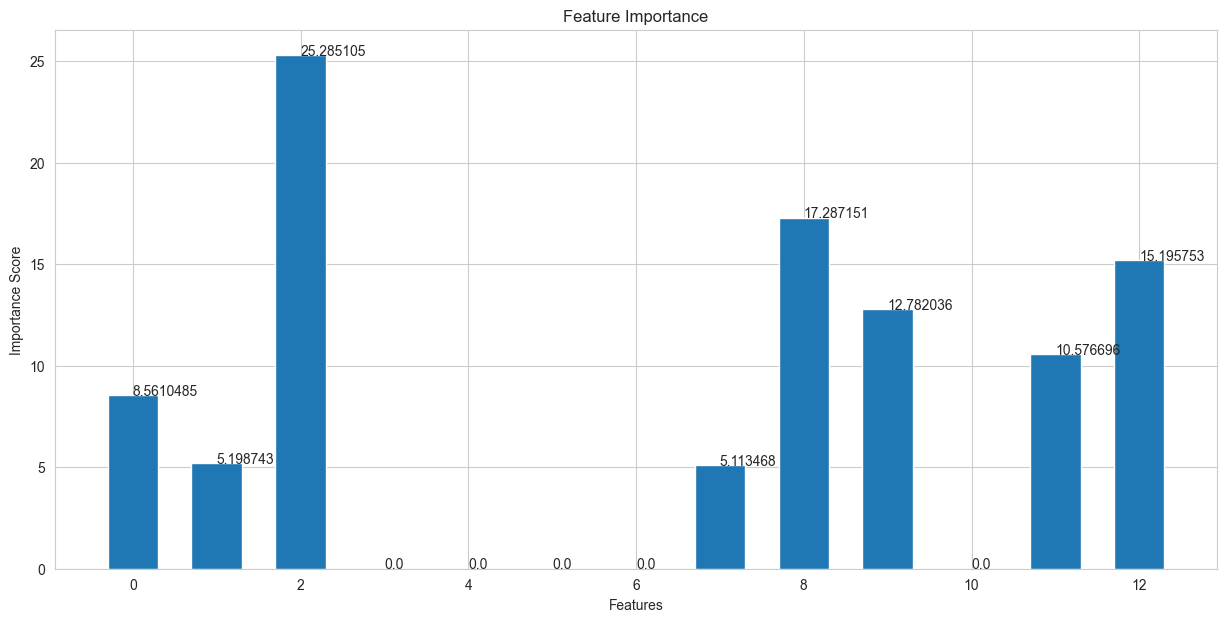

In [35]:
# Identifying feature importance for modelling

plt.figure(figsize = (15, 7))

plt.bar([i for i in range(len(X.columns))], feature_importances, width = 0.6)
for i in range(len(X.columns)):
    plt.text(i, feature_importances[i], feature_importances[i])
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Feature Importance")

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

c:\Users\dell\miniconda3\envs\tf_cpu\Lib\site-packages\h5py\__init__.py:36: UserWarning:

h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems



In [37]:
# Reduce learning rate when no improvement in target metric
reducelr_on_plt = ReduceLROnPlateau(monitor = 'val_loss',
                                    factor = 0.1,
                                    patience = 5,
                                    verbose = 0,
                                    mode = 'auto', 
                                    min_delta = 0.001,
                                    min_lr = 0.001)

# Early stopping to reduce overfitting
early_stopping_monitor = EarlyStopping(monitor = 'val_loss', 
                                       verbose = 0, 
                                       patience = 20, 
                                       baseline = 0.3)

best_trained_model_file = 'best_trained_model.h5'

# Saving model after epoch
checkpoint = ModelCheckpoint(best_trained_model_file, 
                             verbose = 0,
                             monitor = 'val_loss', 
                             save_best_only = True, 
                             mode = 'auto')

callbacks = [checkpoint, reducelr_on_plt]
callbacks = [early_stopping_monitor]

In [38]:
# Defining model architecture

model = keras.Sequential([
    keras.Input(shape = (13)),
    layers.Dense(64, kernel_initializer = 'normal',  kernel_regularizer=regularizers.l2(0.001), activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(32, kernel_initializer = 'normal',  kernel_regularizer=regularizers.l2(0.001), activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(64, kernel_initializer = 'normal',  kernel_regularizer=regularizers.l2(0.001), activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(128, kernel_initializer = 'normal',  kernel_regularizer=regularizers.l2(0.001), activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(32, kernel_initializer = 'normal',  kernel_regularizer=regularizers.l2(0.001), activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(1, kernel_initializer = 'normal',  kernel_regularizer=regularizers.l2(0.001), activation = 'sigmoid'),
])

In [39]:
# Compiling model
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'],
)

# Parameters summary
#model.summary()

In [40]:
# Mdel fitting
history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    validation_split = 0.25, 
    epochs = 100,
    batch_size = 64,
    #callbacks = callbacks,
    verbose = 2
)

Epoch 1/100
4/4 - 10s - loss: 0.7221 - accuracy: 0.5402 - val_loss: 0.7361 - val_accuracy: 0.5333 - 10s/epoch - 2s/step
Epoch 2/100
4/4 - 0s - loss: 0.6644 - accuracy: 0.6964 - val_loss: 0.7358 - val_accuracy: 0.5333 - 89ms/epoch - 22ms/step
Epoch 3/100
4/4 - 0s - loss: 0.6255 - accuracy: 0.7500 - val_loss: 0.7353 - val_accuracy: 0.5333 - 101ms/epoch - 25ms/step
Epoch 4/100
4/4 - 0s - loss: 0.6101 - accuracy: 0.7723 - val_loss: 0.7347 - val_accuracy: 0.5333 - 81ms/epoch - 20ms/step
Epoch 5/100
4/4 - 0s - loss: 0.5744 - accuracy: 0.7857 - val_loss: 0.7338 - val_accuracy: 0.5333 - 100ms/epoch - 25ms/step
Epoch 6/100
4/4 - 0s - loss: 0.5171 - accuracy: 0.8571 - val_loss: 0.7327 - val_accuracy: 0.5333 - 86ms/epoch - 21ms/step
Epoch 7/100
4/4 - 0s - loss: 0.5162 - accuracy: 0.8259 - val_loss: 0.7312 - val_accuracy: 0.5333 - 73ms/epoch - 18ms/step
Epoch 8/100
4/4 - 0s - loss: 0.4993 - accuracy: 0.8482 - val_loss: 0.7293 - val_accuracy: 0.5333 - 88ms/epoch - 22ms/step
Epoch 9/100
4/4 - 0s - l

In [41]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 7ms/step - loss: 0.6292 - accuracy: 0.8000


[0.6291882395744324, 0.800000011920929]

In [42]:
history = history.history
history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [43]:
acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

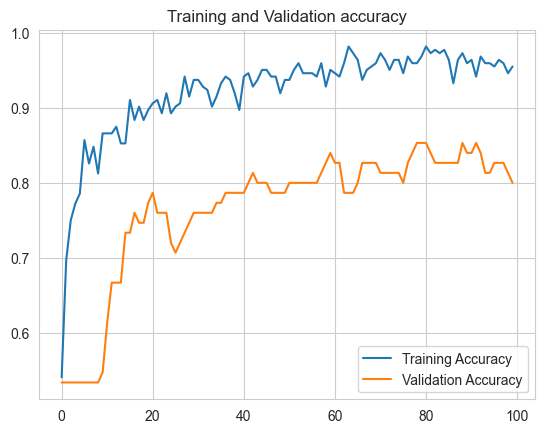

In [44]:
plt.plot(acc, label = "Training Accuracy")
plt.plot(val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Training and Validation accuracy")
plt.show()

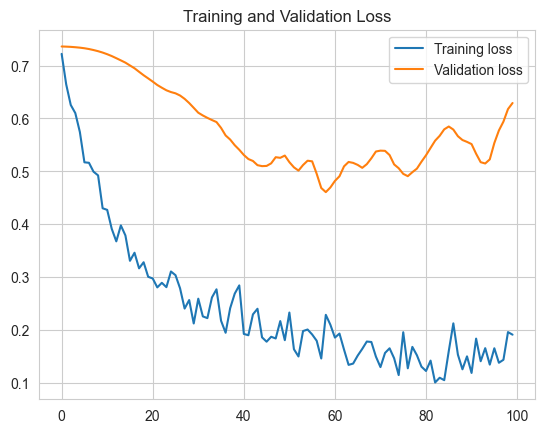

In [45]:
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label = "Validation loss")
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")
plt.show()

In [46]:
# Evaluate model against seen and unseen data
train_score = model.evaluate(X_train, y_train, verbose = 0)
print("Evaluation score with training data: %.2f%%" % (train_score[1] * 100))

test_score = model.evaluate(X_test, y_test, verbose = 0)
print("Evaluation score with validating data: %.2f%%" % (test_score[1] * 100))



Evaluation score with training data: 97.77%
Evaluation score with validating data: 80.00%


In [47]:
# Visualising model actual and predicted class and probability
print("Model prediction testing")
y_pred_class = model.predict(X_test)
y_pred_class = np.argmax(y_pred_class, axis = -1)
y_pred_prob = model.predict(X_test)

print("Index Actual | Predicted | Probability")
for idx, label in enumerate(y_test):
    print("%s  |  %s  |  %s  |   %.2f%%" % (str(idx), str(label), str(y_pred_class[idx]), float(y_pred_prob[idx])*100))
    
print("Accuracy Score: %.2f%%" % (accuracy_score(y_test, y_pred_class) * 100))

Model prediction testing
3/3 [==============================] - 0s 5ms/step
Index Actual | Predicted | Probability
0  |  1  |  0  |   98.95%
1  |  0  |  0  |   2.49%
2  |  1  |  0  |   98.21%
3  |  0  |  0  |   1.38%
4  |  1  |  0  |   95.18%
5  |  0  |  0  |   1.55%
6  |  1  |  0  |   1.42%
7  |  0  |  0  |   0.91%
8  |  1  |  0  |   98.90%
9  |  0  |  0  |   76.28%
10  |  1  |  0  |   99.39%
11  |  0  |  0  |   2.43%
12  |  0  |  0  |   79.82%
13  |  0  |  0  |   52.98%
14  |  0  |  0  |   1.52%
15  |  0  |  0  |   41.37%
16  |  1  |  0  |   99.06%
17  |  1  |  0  |   18.28%
18  |  1  |  0  |   92.21%
19  |  1  |  0  |   95.50%
20  |  1  |  0  |   91.69%
21  |  0  |  0  |   6.87%
22  |  0  |  0  |   1.55%
23  |  0  |  0  |   1.79%
24  |  1  |  0  |   98.56%
25  |  1  |  0  |   97.91%
26  |  0  |  0  |   1.09%
27  |  1  |  0  |   98.10%
28  |  1  |  0  |   62.37%
29  |  0  |  0  |   2.92%
30  |  0  |  0  |   4.18%
31  |  0  |  0  |   99.46%
32  |  0  |  0  |   10.41%
33  |  0  |  0  |

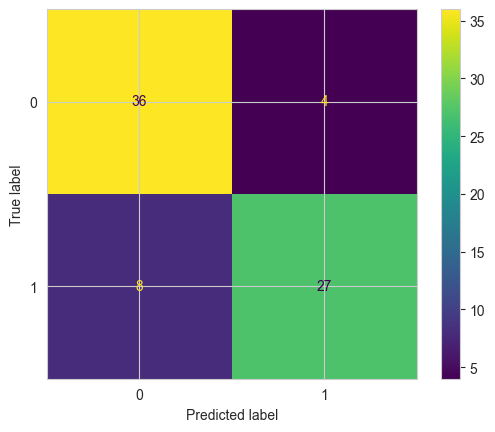

In [48]:
# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

conf_mat = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

conf_mat.plot()
plt.show()

In [49]:
tf.math.confusion_matrix(
    y_test,
    y_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[36,  4],
       [ 8, 27]])>